All Functions:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

pi=np.pi

#getval input:a,f,phi,starting point,endingpoint,no. of steps
def getval(a,phi,f,sp,ep,n):
    a=a
    f=f
    phi=phi
    t=np.linspace(sp,ep,n)
    return a,phi,f,t

def signal(a,phi,f,t):
    return a*np.sin(2*pi*f*t+phi)

def noise(m,std,n):
    return np.random.normal(m,std,n)

#al parameters have uniform distribution--known priors
'''
P(a)=U[0,10]
P(phi)=U[0,2*pi]
P(f)=U[1,10]
'''

def randomparam(n):
    arr_a=np.random.uniform(0,10,n).reshape(-1,1)
    arr_phi=np.random.uniform(0,2*pi,n).reshape(-1,1)
    arr_f=np.random.uniform(1,10,n).reshape(-1,1)
    return arr_a,arr_phi,arr_f

def randomsignalarr(n,t):
    arr_a,arr_phi,arr_f=randomparam(n)
    arr_sig=signal(arr_a,arr_phi,arr_f,t)
    return np.concatenate((arr_a,arr_phi,arr_f,arr_sig),axis=1),arr_a,arr_phi,arr_f

def likelihood(datastrain,signal,std):
    l=len(datastrain)
    lh = -(l/2)*np.log(2*np.pi*std**2)-np.sum((datastrain-signal)**2/(2*std**2))
    return lh

def likelihoodarr(datastrain,signalarr,std):
    lha=[]
    for i in range(signalarr.shape[0]):
        lha.append(likelihood(datastrain,signalarr[i][3:],std))
    lha=np.array(lha).reshape(-1,1)
    return np.concatenate((signalarr,lha),axis=1)

def newsignalarr(d,t,std):
    a=np.random.uniform(0,10)
    phi=np.random.uniform(0,2*pi)
    f=np.random.uniform(1,10)
    newsig = signal(a,phi,f,t)
    rsarr=np.concatenate((np.array([a,phi,f]),newsig,[likelihood(d,newsig,std)]),axis=0)
    return rsarr


#sampling
def lowestlh(lha):
    return np.argmin(lha[:,-1])

def checkchange(new,old,checkarr):
    checkarr=np.delete(checkarr,0)
    if abs(new-old)<=0.075: 
        checkarr=np.append(checkarr,0)
    else:  
        checkarr=np.append(checkarr,1)  
    print(new,old)     
    return np.sum(checkarr)>0, checkarr

def nestedsampling(lha,data,std,t):
    newsamplespace=[]
    checkarr=np.ones(5)
    arg=lowestlh(lha)
    nsarr=newsignalarr(data,t,std)
    while(nsarr[-1]<=lha[arg][-1]):
        nsarr=newsignalarr(data,t,std)   

    dup=np.copy(lha[arg])
    newsamplespace.append(dup)
    lha[arg]=np.copy(nsarr)
    cond=True
    n=0
    
    while(cond and n<1500):
        arg=lowestlh(lha)
        nsarr=newsignalarr(data,t,std)
        
        while(nsarr[-1]<=lha[arg][-1]):
            nsarr=newsignalarr(data,t,std)
          
        cond,checkarr=checkchange(lha[arg][-1],newsamplespace[-1][-1],checkarr)   
        newsamplespace.append(np.copy(lha[arg])) 
       
        n+=1
        print(n,checkarr)
        lha[arg]=np.copy(nsarr)

    return np.array(newsamplespace) 

Calling functions:

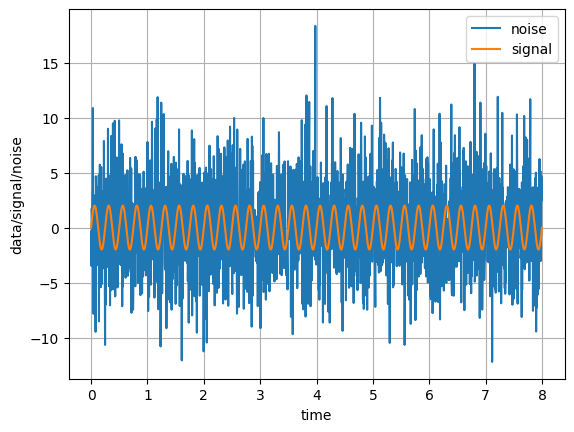

[-8681.27366348897, -8607.751658395746, -8457.126674419556, -8410.15851127738, -7858.789037385107, -7489.180112224423, -7432.005710841142, -7100.9799570513915, -6848.023531400828, -6553.20103326095, -6423.335927748466, -6283.069822694189, -6113.506661849231, -6048.451907071195, -6033.038840781968, -6021.51138059624, -6009.078384883371, -5944.1022659650835, -5774.412043629602, -5733.102842787697]
-8607.751658395746 -8681.27366348897
1 [1. 1. 1. 1. 1.]
-8457.126674419556 -8607.751658395746
2 [1. 1. 1. 1. 1.]
-8410.15851127738 -8457.126674419556
3 [1. 1. 1. 1. 1.]
-7858.789037385107 -8410.15851127738
4 [1. 1. 1. 1. 1.]
-7489.180112224423 -7858.789037385107
5 [1. 1. 1. 1. 1.]
-7432.005710841142 -7489.180112224423
6 [1. 1. 1. 1. 1.]
-7100.9799570513915 -7432.005710841142
7 [1. 1. 1. 1. 1.]
-7064.888571828491 -7100.9799570513915
8 [1. 1. 1. 1. 1.]
-6858.222592786227 -7064.888571828491
9 [1. 1. 1. 1. 1.]
-6848.023531400828 -6858.222592786227
10 [1. 1. 1. 1. 1.]
-6553.20103326095 -6848.0235314

In [11]:
std=4
mean=0
a,phi,f,t=getval(2,0,4,0,8,8000)
arr_sig,arr_a,arr_phi,arr_f=randomsignalarr(16,t)
injn=noise(mean,std,len(t))
injsig=signal(a,phi,f,t)
data=injn+injsig

plt.plot(t,injn, label='noise')
plt.plot(t, injsig, label='signal')
#plt.plot(t, data, label='data')
plt.grid()
plt.xlabel('time')
plt.ylabel('data/signal/noise')
plt.legend()
plt.show()

lha=likelihoodarr(data,arr_sig,4)
print(sorted(lha[:,-1]))
newsamplespace=nestedsampling(lha,data,std,t)

Plotting

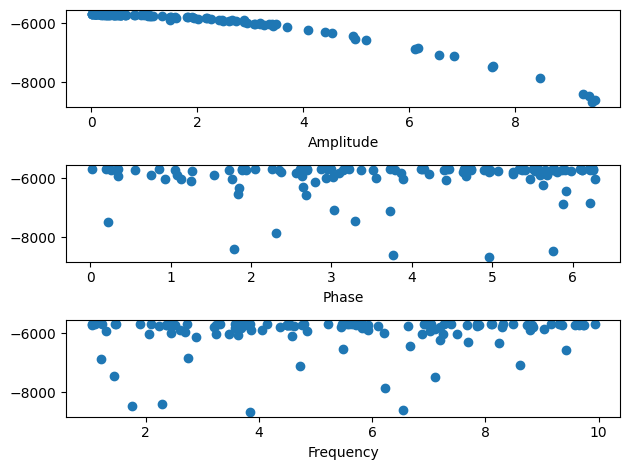

In [12]:
newss=newsamplespace
arr_a=newss[:,0]
arr_phi=newss[:,1]
arr_f=newss[:,2]
nss=newss[:,-1]


def plotter(x, y, z, a):
    figure, axis = plt.subplots(3, 1)
    axis[0].scatter(x, a)
    axis[0].set_xlabel("Amplitude")
    axis[1].scatter(y, a)
    axis[1].set_xlabel("Phase")
    axis[2].scatter(z, a)
    axis[2].set_xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plotter(arr_a, arr_phi, arr_f,nss)